In [1]:
import gensim.downloader
import pandas as pd
import numpy as np
import torch
import random
from nltk.tokenize import word_tokenize
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
import datasets
import matplotlib.pyplot as plt

# enabling inline plots in Jupyter
%matplotlib inline
datasets.logging.set_verbosity_error()

# Exercise: word embeddings

In this exercise set, we will be playing around with word embeddings. First, we will be exploring and comparing a few different pre-trained word embeddings, trained on huge data sets. We will try to vizualize some of the embeddings from one of these models in a two-dimensional space. Next, we will examine the embeddings by looking at the neighbors of some political terms. We will also look at whteher these embeddings contain any gender bias. Finally, we will train our own embeddings on a data set of speeches by Donald Trump.

# 1. Visualizing word embeddings

1. Use [Gensim](https://radimrehurek.com/gensim/) (in particular, the `gensim.downloader.load()` module) to download and import 3 GloVe word embeddings: `glove-wiki-gigaword-50`, `glove-twitter-50`, `glove-twitter-200`. The wiki-gigaword embeddings were trained on a combination of wikipedia and Gigaword corpus. The twitter embeddings were trained on a corpus of tweets. They also contain word embeddings of different lengths (50 and 200 dimensions for Twitter, 50 for wiki+gigaword).
2. Let's see what the `glove_twitter_50` embeddings look like if we try to plot them in a two-dimensional space. Complete the code below to create a [T-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) visualization of the 200 most common words in the corpus that the embeddings were trained on.

Hint: You can retrieve the embeddings of a list of words from a gensim embeddig model like so: `embedding[words]`. [This](https://radimrehurek.com/gensim/models/word2vec.html) documentation can help find you find other useful methods for the embeddings. That said, tools like Google are always useful to find necessary documentation and other resources.

In [2]:
#download gloves
glove_wiki_50 = 
glove_twitter_50 = 
glove_twitter_200 = 

In [3]:
# let's try to see what these embeddings look like in 2D space

embedding =   # fill in the desired embedding

# Get first 200 words of words for visualization
words = list(embedding.key_to_index.keys())[:200]

# Get the corresponding vectors for the words
word_vectors = 

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = 

# Extract x and y coordinates
x_coords = reduced_vectors[:, 0]
y_coords = 

# Plot the embeddings
plt.figure(figsize=(12, 12))
plt.scatter(x_coords, y_coords)

# Add labels for each point
for i, word in enumerate(words):
    plt.annotate(word, (x_coords[i], y_coords[i]))

plt.title('t-SNE Visualization of Word Embeddings')
plt.show()


# 2. Exploring similar words

1. Find the top 10 similar words to the word "republican" in all three models above, using the [similar_by_word](https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.similar_by_word.html) method. How similar are the models? How many words in this neighborhood overlap between the two Twitter models, and the two 50-dimensional models?
2. Find what is the neighbor rank of "democrat" to "republican" in all three models (democrat is the how-manieth-closest neighbor of republican?).


In [1]:
# Find the top 10 similar words to the word "republican" in all three models  


In [5]:
# Get the top n similar words using glove-wiki-gigaword-50 embedding

# Find the intersection of similar words between glove-twitter-50 and glove-twitter-200 embeddings


In [6]:
# Find what is the neighbor rank of "democrat" to "republican" in all three models.


# 3. Bias in embeddings

Let's investigate what our embedding models have learned about which professions are associated with which genders. Use the [most_similar](https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.most_similar.html) method to solve analogies with the GloVe wiki + Gigaword embeddings. Follow the example below, and then insert your own professions which might be associated with one gender.

This section of the paper harks back to the, now famous, [article](https://arxiv.org/abs/1310.4546) that found the geometry of embedding vectors to mirror semantic logic, whereby vector algebra yields:

v_King - v_Man + v_Woman = v_Queen

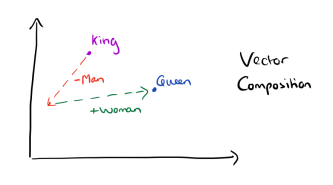

In [37]:
#this example code solves the analogy: "he is to doctor as she is to?"
glove_wiki_50.most_similar(positive=['she', 'doctor'], negative=['he'])

[('nurse', 0.8434410095214844),
 ('mother', 0.7978049516677856),
 ('child', 0.7920326590538025),
 ('woman', 0.7831878066062927),
 ('pregnant', 0.7726936936378479),
 ('girl', 0.7672077417373657),
 ('her', 0.7481821775436401),
 ('patient', 0.7464373707771301),
 ('boy', 0.7313278913497925),
 ('learns', 0.7268911600112915)]

In [38]:
#this example code solves the analogy: "man is to programmer as woman is to?"
glove_wiki_50.most_similar(positive=['woman', 'programmer'], negative=['man'])

[('prodigy', 0.6731117367744446),
 ('therapist', 0.6414064764976501),
 ('psychotherapist', 0.6201493144035339),
 ('technician', 0.6191534996032715),
 ('programmers', 0.59874427318573),
 ('educator', 0.5932906866073608),
 ('psychologist', 0.5907979607582092),
 ('installer', 0.5891358256340027),
 ('acrobat', 0.5890737771987915),
 ('indian-american', 0.5828383564949036)]

Note: there is an interesting [paper](https://arxiv.org/abs/1905.09866) by Nissim, van Noord and van der Goot (2019) criticizing the use of `gensim`'s `most_similar` analogy-solving method as a way to find bias in embeddings. They argue that first, `most_similar` is not allowed to ouput a word as a solution that is already in the query (e.g. it cannot output `programmer` in the example above). Therefore, we cannot find cases where there is no gender bias at all, where the best answer would be to fill in the same profession on both sides. Second, in light of this, it is actually unclear what a *correct, unbiased* answer to these analogies would look like.

# 4. Training your own word embeddings

Here, we will use Word2Vec to train our own embeddings on a relatively small data set of Trump's speeches during 2016 election campaign. Thus, we will capture the meaning associations between words according to Trump.

To feed this dataset into the embedding model, we will once again use a Dataloader. This time, we will create our own Dataloader class from scratch. The key part of the Dataloader is the `__iter__` method, which allows us to feed inputs to the model one chunk at a time, without loading the whole dataset into memory. This is not so important with a data set this size, but will come in handy when you work with much larger files.

1. Complete the `__iter__` method of the provided data loader class. Right now, it is set up to return one line from the file at a time. Before we return the line, though, we want to tokenize the line with a tokenizer of your choice, e.g. [word_tokenize](https://www.nltk.org/api/nltk.tokenize.word_tokenize.html) form `nltk`. We also want to lowercase it and remove any empty lines. Finally, we want to yield (output) the line in the form of a list of tokens, as that is the input format our Word2Vec model will expect.
2. Create an instance of the data loader class that uses the raw text file of speeches (`trump_speeches.txt`). The file comes from [this repository](https://github.com/ryanmcdermott/trump-speeches), distributed under "fair use".


In [2]:
# exercise template
class MyDataLoader(object):

    # when we initialize this dataloader, it will take a filename as an argument
    def __init__(self, filename):
        self.corpus = filename

    # we will need to define what counts as a "chunk" in this file, so when the
    # Dataloader is loading (iterating over) the file and feeding it to the embedding
    # model, it knows what to treat as one unit. Here, we (arbitrarily) say that one
    # line in the file (corresponding to a paragraph) is one chunk.
    def __iter__(self):
        for line in open(self.corpus, "r", encoding="utf-8"):
            # check that the line is not empty (if it is, do nothing):
            
            # tokenize and lowercase the string before yielding it
            # the output must be a list of tokens in the line
            yield line

In [7]:
# loading Trump speeches with the custom loader


3. Use Gensim to train your own Word2Vec SkipGram embeddings, using this text as a corpus. Use vector size 300, window size 3, 3 epochs. Consider the parameters listed on Gensim's [word2vec reference page](https://radimrehurek.com/gensim/models/word2vec.html).
4. Compare the nearest neighbours of "China" and "Russia" in the Trump's word2vec. How different are they? Are these representations equally reliable? Why or why not?
5. Explore your Trump embeddings with any questions you may have yourself. E.g. what words are associated with "great" for him, and what words are associated with "bad"? Ultimately, do you feel that the embeddings we are getting are meaningful or noisy?

In [67]:
# train the Skip-Gram - model
trump2vec = 


In [8]:
# Compare the nearest neighbours of "China" and "Russia" in the Trump's word2vec. 
